# Demixing Components and Recovering Correlation Structure

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np
import superpixel_analysis as sup
import util_plot

from skimage import io

import scipy.io
from scipy.ndimage import center_of_mass

## Read in movie

(200, 96, 89900)


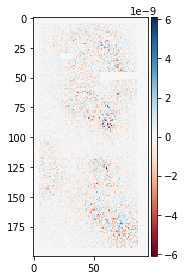

In [2]:
# path = '/n/cohen_lab/Lab/Data and Analysis/Electrochromic Protein/somArchon optopatch in vivo/NMFcorrection_MEX/IVOP21/2019-01-08/slice2/FOV4/161916_PuffTE2/PMD_output_MX'

path = '/n/cohen_lab/Lab/Labmembers/Yoav Adam/Data/In Vivo/PlaceCells/PC1R1/2018-11-16_PC1R1-S1/slice1/FOV3/131943_FreeRun_Dilas-8V_488-OD1.0-Mask0-Pos22/PMD_output'

# read in motion corrected movie
noise = np.squeeze(io.imread(path + '/Sn_image.tif'))
[nrows, ncols] = noise.shape
mov = np.fromfile(path + '/motion_corrected.bin',dtype=np.float32)
mov = np.reshape(mov,(-1, ncols, nrows)).transpose(2,1,0)
mov.shape

# read in the mask for blood
bloodmask = np.squeeze(io.imread(path + '/bloodmask.tif'))

mov_nn = mov.copy() * np.repeat(np.expand_dims(bloodmask,2),mov.shape[2],axis=2)
mov = mov * np.repeat(np.expand_dims(noise * bloodmask,2),mov.shape[2],axis=2)

print(mov.shape)

# Display average movie

io.imshow(np.mean(mov,axis=2))

## Spatial 2x2 Binning

In [3]:
movB = mov.reshape(int(mov.shape[0]/2),2,int(mov.shape[1]/2),2,mov.shape[2])
movB = np.mean(np.mean(movB,axis=1),axis=2)#[60:80,15:40,:]
movB.shape

(100, 48, 89900)

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


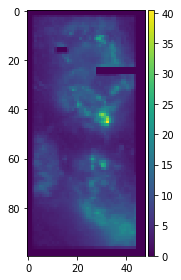

In [4]:
# show standard deviation image of binned movie
io.imshow(np.std(movB,axis=2))

## Get Manually Initialized Background (skip this section for now)

In [ ]:
# import manually initialized background components

ff_ini = io.imread(path + '/ff.tif')
fb_ini = io.imread(path + '/fb.tif')

# bin the spatial components
fb_ini = fb_ini.reshape(mov.shape[1],mov.shape[0],-1).transpose(1,0,2)
fb_ini = fb_ini.reshape(int(fb_ini.shape[0]/2),2,int(fb_ini.shape[1]/2),2,fb_ini.shape[2])
fb_ini = np.mean(np.mean(fb_ini,axis=1),axis=2)#[60:80,15:40,:]

fb_ini.shape

# plot manually initialized background components

plt.figure(figsize=(30,20))

for i in range(6):
    plt.subplot(3,4,2*i+1)
    plt.plot(ff_ini[:2000,i])
    plt.subplot(3,4,2*i+2)
    io.imshow(fb_ini[:,:,i])

In [509]:
# select which background components to use for initialization
bkg_components = (0,1,2)

fb_ini = fb_ini[:,:,bkg_components].reshape(movB.shape[0]*movB.shape[1],len(bkg_components))
ff_ini = ff_ini[:,bkg_components]

## Demix movie components

In [18]:
start = time.time()

bg_rank = 3 # if background is not manually initialized above, set desired background rank here

rlt=sup.axon_pipeline_Y(movB[:,:,:10000].copy(), 
                        fb_ini=np.zeros(1), # manually initialized background location, set to np.zeros(1) if not initialized
                        ff_ini=np.zeros(1), # manually initialized background, traces set to np.zeros(1) if not initialized
                        
                        ##### Superpixel parameters
                        th = [2,2,2,2],
                        cut_off_point = [0.94,0.92,0.89,0.86], # correlation threshold for finding superpixels (range around 0.8-0.99)
                        length_cut = [10,10,10,10], # minimum pixel count of a superpixel
                        length_max = [1000,1000,1000,1000], # maximum pixel count of a superpixel
                        patch_size=[30,30], 
                        residual_cut = [np.sqrt(1-(0.9)**2),np.sqrt(1-(0.85)**2),np.sqrt(1-(0.85)**2),np.sqrt(1-(0.8)**2)], # correlation threshold between superpixels for merging
                        pass_num = 4,
                        bg = bg_rank, 
                        
                        ##### Cell-finding, NMF parameters
                        corr_th_fix=0.3, # correlation threshold of pixel with superpixel trace to include pixel in cell
                                         # range 0.3-0.6
                        merge_corr_thr=0.9, # correlation threshold for merging two cells
                                            # default 0.8
                        
                        ##### Other options
                        sup_only = False, # if True, only superpixel analysis run; if False, NMF is also run to find cells
                        remove=0
                       )

print("Demixing took: " + str(time.time()-start)+" sec")

start 1 pass!
find superpixels!


/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:265: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Yt.transpose(2,0,1) - np.mean(Yt, axis=2)) / np.std(Yt, axis=2);


3.0667190551757812
rank 1 svd!
6.066777229309082
find pure superpixels!
0.12831902503967285
prepare iteration!
0.48205018043518066
2.5967512130737305
start 1 pass iteration!
a.shape = (4800, 9); c.shape = (10000, 9)


/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2285: RuntimeWarning: divide by zero encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2285: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);


time: 0.8495256900787354
time: 0.8634662628173828
time: 0.842212438583374


/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2313: RuntimeWarning: divide by zero encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2313: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2143: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);


no merge!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 5.232755661010742
time: 0.8529772758483887
time: 0.8895649909973145
time: 0.8692200183868408


/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/scipy/sparse/base.py:594: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2146: RuntimeWarning: invalid value encountered in greater
  cri = np.asarray((cor_corr/(temp.T)) > merge_overlap_thr)*np.asarray((cor_corr/temp) > merge_overlap_thr)*((a_corr>0).toarray());#.toarray())*(((cor_corr/(temp.T)) > merge_overlap_thr).toarray())*((a_corr > 0).toarray());


no merge!
time: 5.422725677490234
time: 0.8749377727508545
time: 0.8335742950439453
time: 0.8316454887390137
no merge!
time: 5.16796612739563
time: 0.832007646560669
time: 0.8425583839416504
time: 0.8445243835449219
no merge!
time: 5.177961587905884
time: 0.8327157497406006
time: 0.8339223861694336
time: 0.8386988639831543
no merge!
time: 5.252586841583252
time: 0.8557932376861572
time: 0.84189772605896
time: 0.8406054973602295
no merge!
time: 5.150022983551025
time: 0.8347122669219971
time: 0.8273613452911377
time: 0.836296796798706
no merge!
time: 5.16617226600647
time: 0.8423523902893066
time: 0.8447873592376709
time: 0.840503454208374
no merge!
time: 5.147302865982056
time: 0.8349132537841797
time: 0.840740442276001
time: 0.8499705791473389
71.54453253746033
start 2 pass!
find superpixels!
2.109450578689575
rank 1 svd!
0.3295869827270508
find pure superpixels!
0.011441946029663086
prepare iteration!
0.3102376461029053
start 2 pass iteration!
a.shape = (4800, 12); c.shape = (10000, 

## Display initial demixing results (superpixels, pure superpixels, and components) 

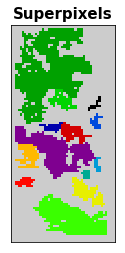

In [19]:
# plot superpixels
z = sup.superpixel_single_plot(rlt["superpixel_rlt"][0]["connect_mat_1"],
                           np.arange(np.amax(rlt["superpixel_rlt"][0]["connect_mat_1"])-1),
                           rlt["superpixel_rlt"][0]["brightness_rank"],
                           text=False)

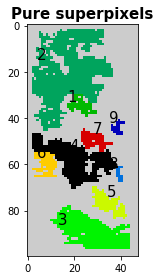

In [20]:
# plot pure superpixels
sup.pure_superpixel_single_plot(rlt["superpixel_rlt"][0]["connect_mat_1"],
                                rlt["superpixel_rlt"][0]["pure_pix"],
                                rlt["superpixel_rlt"][0]["brightness_rank"],text=True);

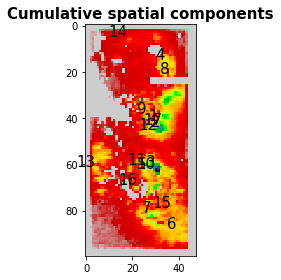

In [21]:
# plot the cell spatial footprints
sup.spatial_sum_plot_single((rlt["fin_rlt"]["a"]),movB.shape[:2],text=True);

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


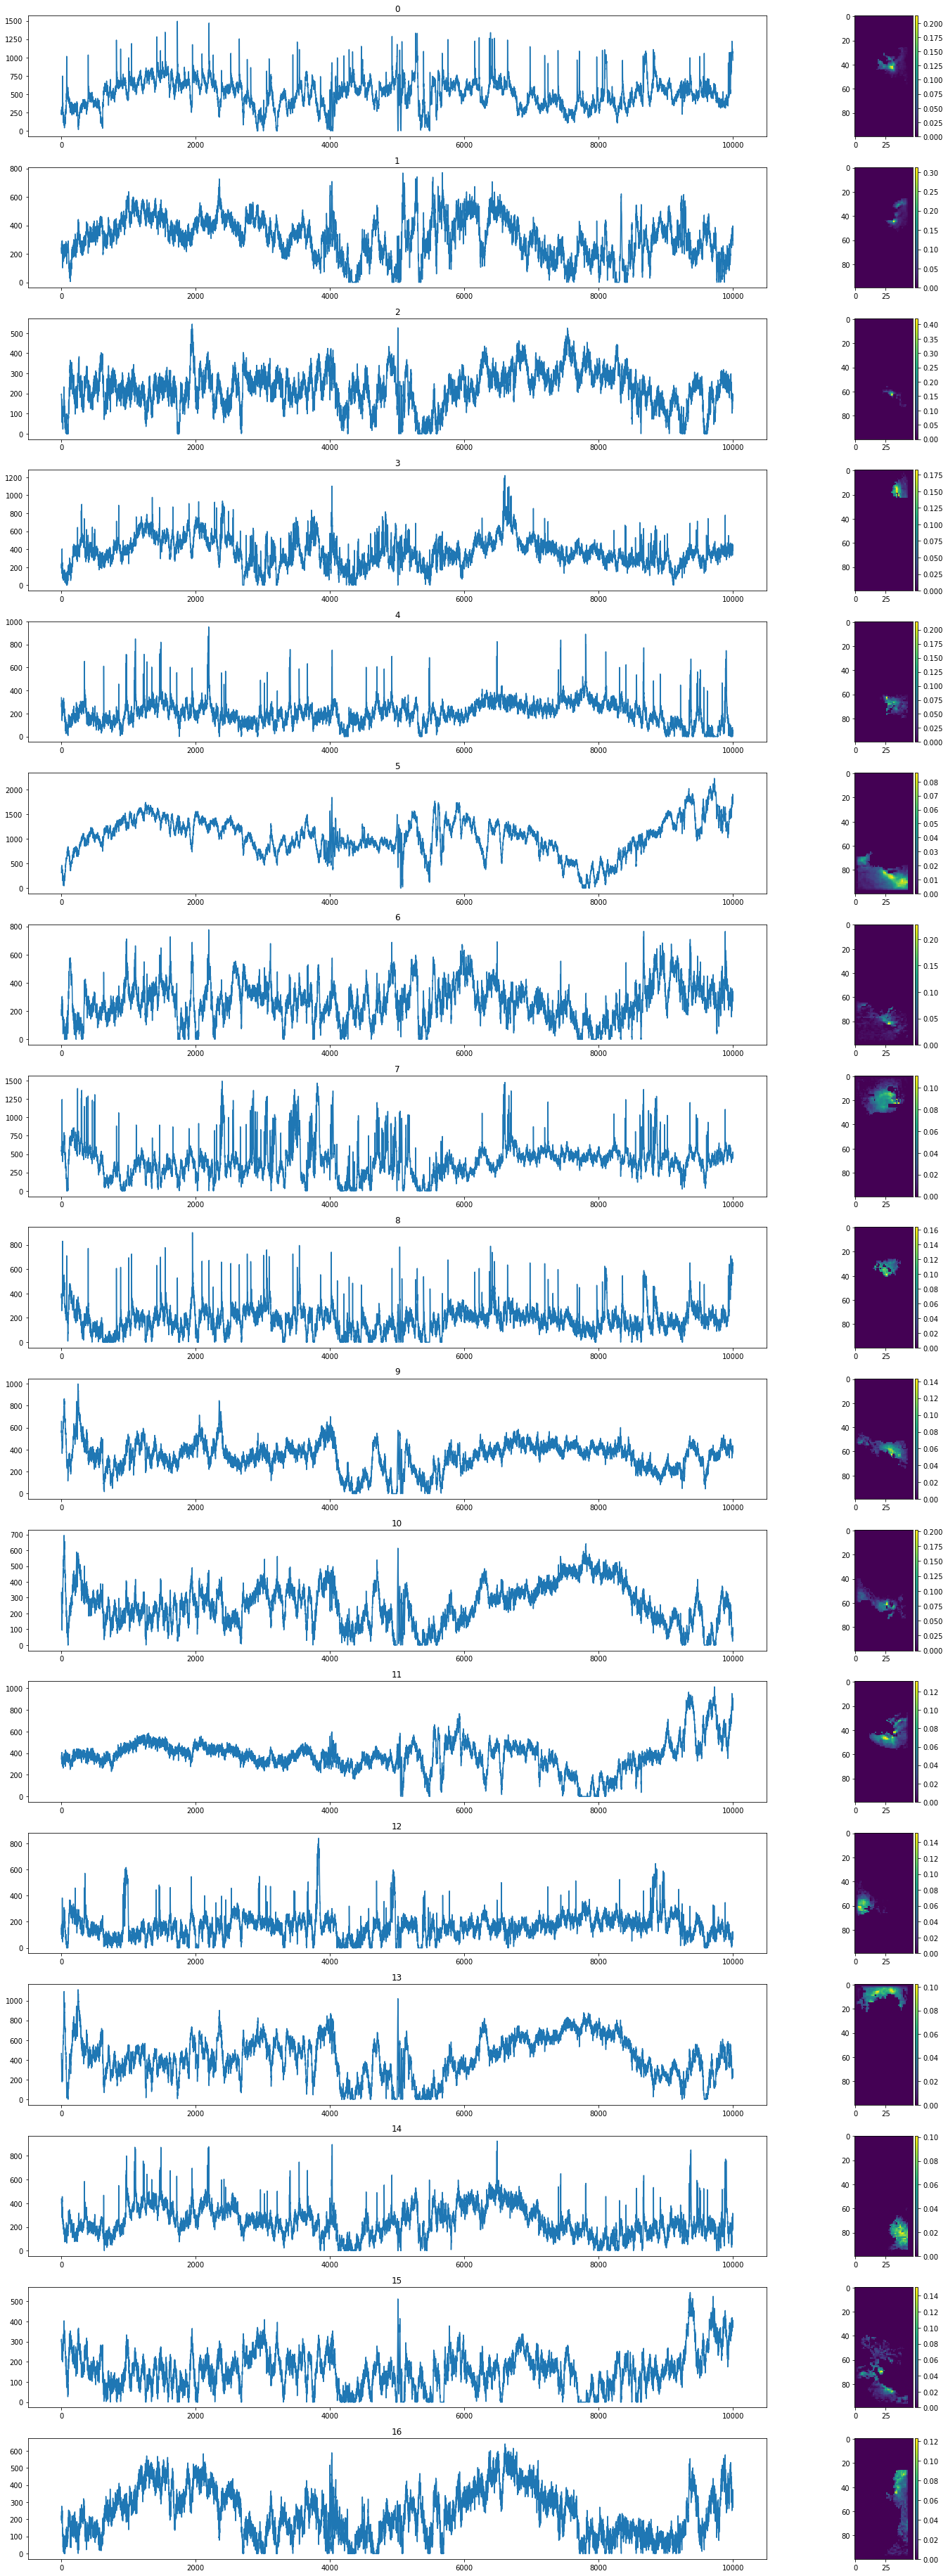

In [30]:
# plot all cell traces and footprints from NMF
cell_ct = rlt["fin_rlt"]["c"].shape[1]

plt.figure(figsize=(25,3*cell_ct))

for cell_num in range(cell_ct):
    plt.subplot(cell_ct,2,2*cell_num+1)
    plt.plot(rlt["fin_rlt"]["c"][:,cell_num])
    plt.title(cell_num)
    plt.subplot(cell_ct,2,2*cell_num+2)
    io.imshow(rlt["fin_rlt"]["a"][:,cell_num].reshape(movB.shape[1],movB.shape[0]).transpose(1,0))

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


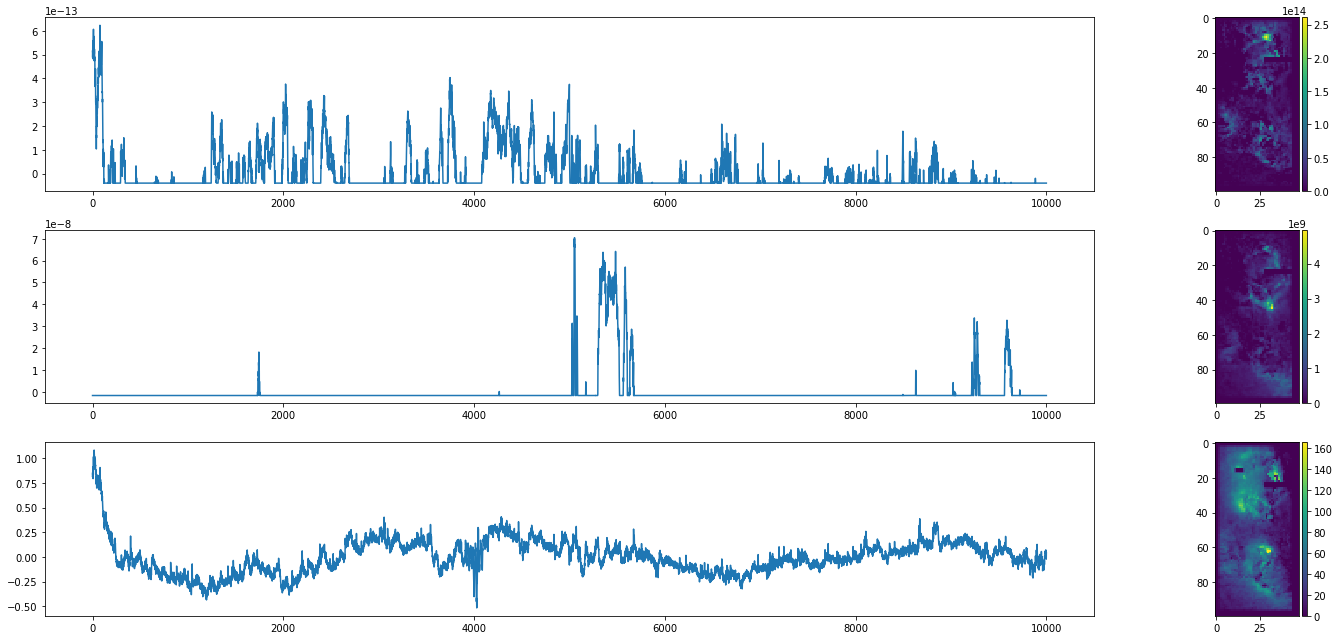

In [23]:
# plot all background traces and footprints

plt.figure(figsize=(25,3*bg_rank))
for bkgd_num in range(bg_rank):
    plt.subplot(bg_rank,2,2*bkgd_num+1)
    plt.plot(rlt["fin_rlt"]["ff"][:,bkgd_num])
    plt.subplot(bg_rank,2,2*bkgd_num+2)
    io.imshow(rlt["fin_rlt"]["fb"][:,bkgd_num].reshape(movB.shape[1::-1]).transpose(1,0))

## Recover Temporal Correlation Structures

In [34]:
Y = movB.transpose(1,0,2).reshape(movB.shape[0] * movB.shape[1], movB.shape[2])
X = np.hstack((rlt["fin_rlt"]["a"] * rlt["fin_rlt"]["c"][300,:],
               rlt["fin_rlt"]["fb"] * rlt["fin_rlt"]["ff"][300,:]))

In [48]:
final_cells = (4,7,8,12) # good cell components to keep
nCells = len(final_cells)

w = np.linalg.lstsq(np.hstack((X[:,final_cells],np.ones(X[:,:1].shape))), X[:,-bg_rank:])[0]

X2 = np.zeros((X.shape[0],nCells + bg_rank))
X2[:,:nCells] = X[:,final_cells] + X[:,final_cells] * np.repeat(np.expand_dims(np.sum(w[:nCells,:],axis=1),axis=1)
                                                        .transpose(1,0),X.shape[0],axis=0)
X2[:,nCells:] = X[:,-bg_rank:] - X[:,final_cells] @ w[:nCells,:]

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


## Get final temporal traces

(100, 48, 89900)

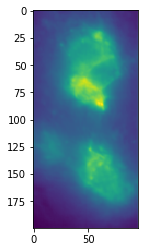

In [49]:
trend = io.imread(path + '/trend.tif')
plt.imshow(np.mean(trend,axis=2))
trendB = trend.reshape(int(trend.shape[0]/2),2,int(trend.shape[1]/2),2,trend.shape[2])
trendB = np.mean(np.mean(trendB,axis=1),axis=2)#[60:80,15:40,:]
trendB.shape

In [53]:
Y = (movB+trendB).transpose(1,0,2).reshape(movB.shape[0] * movB.shape[1], movB.shape[2])

In [54]:
beta_hat2 = np.linalg.lstsq(X2, Y)[0]
res = np.mean(np.square(Y - X2 @ beta_hat2),axis = 0)

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


## Visualizations

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


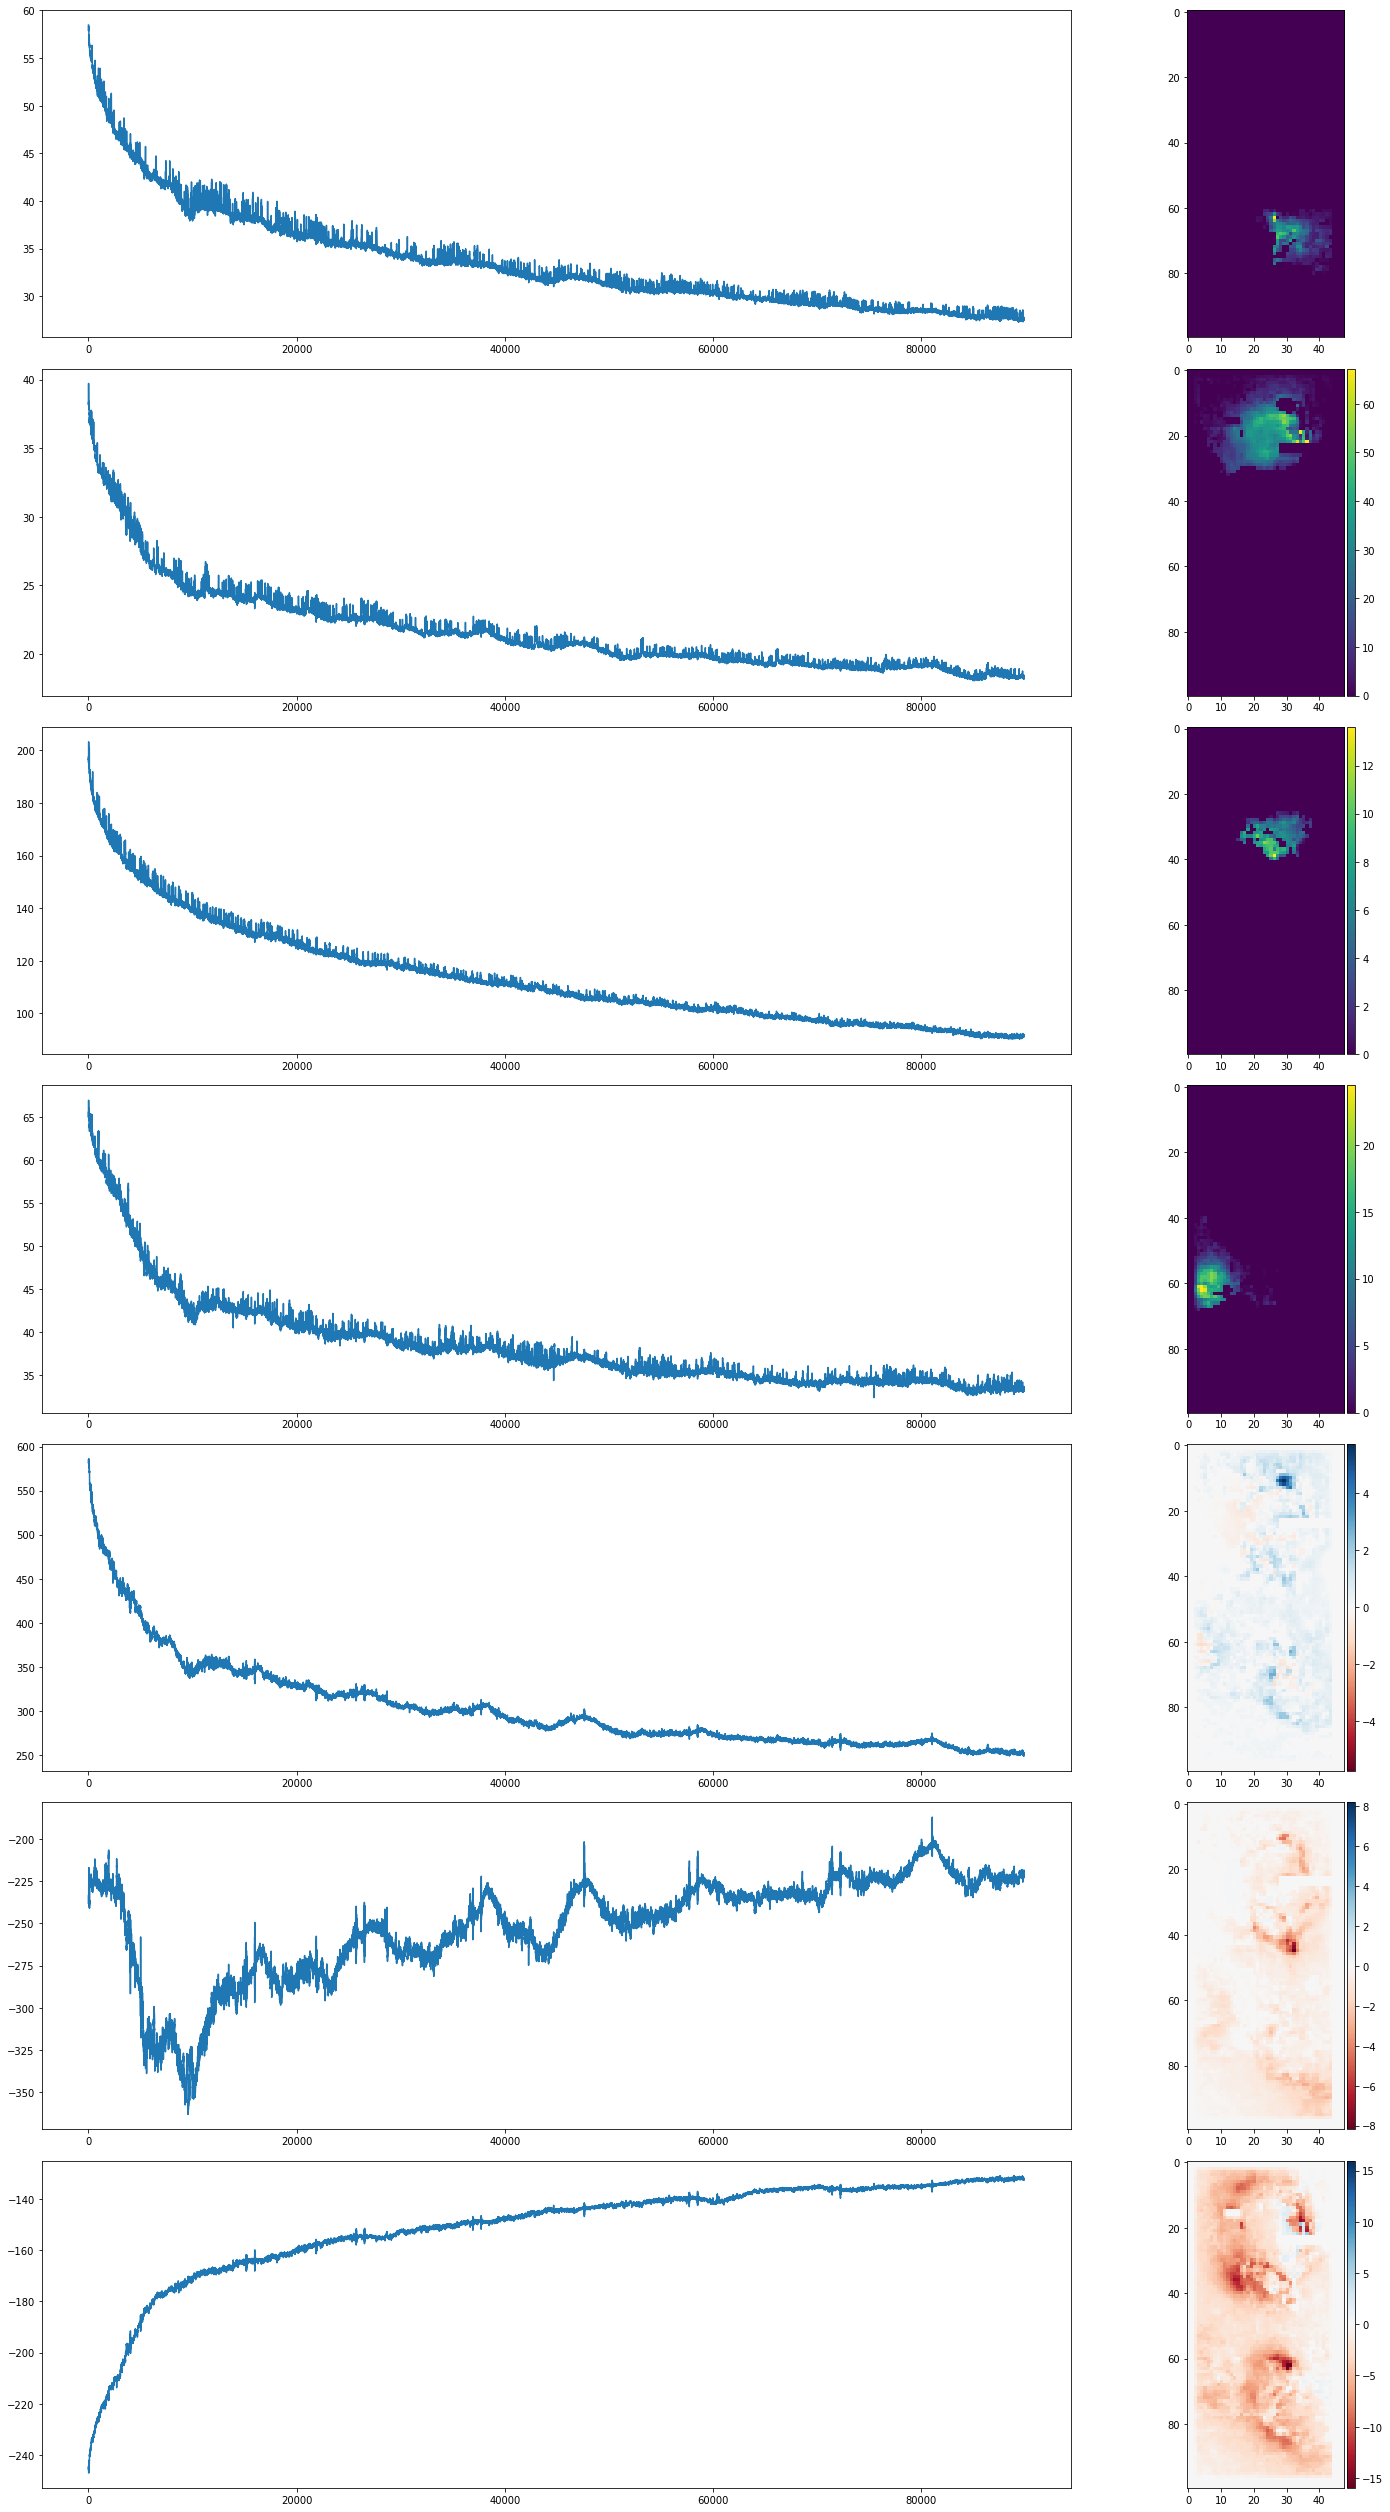

In [55]:
num_traces = beta_hat2.shape[0]
plt.figure(figsize=(25,5*num_traces))

for idx in range(num_traces):
    plt.subplot(num_traces,2,2*idx+1)
    plt.plot(beta_hat2[idx,:])
    plt.subplot(num_traces,2,2*idx+2)
    io.imshow(X2[:,idx].reshape(movB.shape[1::-1]).transpose(1,0))

## Save Results

In [56]:
io.imsave(path + '/spatial_footprints.tif', X2)
io.imsave(path + '/cell_spatial_footprints.tif', X2[:,:nCells])
io.imsave(path + '/temporal_traces.tif', beta_hat2)
io.imsave(path + '/cell_traces.tif', beta_hat2[:nCells,:])
io.imsave(path + '/residual_var.tif', res)

cell_locations = center_of_mass(X2[:,0].reshape(movB.shape[1::-1]).transpose(1,0))
for idx in range(nCells - 1):
    cell_locations = np.vstack((cell_locations, 
                                center_of_mass(X2[:, idx + 1].reshape(movB.shape[1::-1]).transpose(1,0))))
io.imsave(path + '/cell_locations.tif', np.array(cell_locations))

if nCells > 1:
    io.imsave(path + '/cell_demixing_matrix.tif', 
              np.linalg.inv(np.array(X2[:,:nCells].T @ X2[:,:nCells])) @ X2[:,:nCells].T)

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /n/cohen_lab/Lab/Labmembers/Yoav Adam/Data/In Vivo/PlaceCells/PC1R1/2018-11-16_PC1R1-S1/slice1/FOV3/131943_FreeRun_Dilas-8V_488-OD1.0-Mask0-Pos22/PMD_output/cell_demixing_matrix.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [189]:
signal2 = X2[:,:nCells] @ beta_hat2[:nCells,:15000]
background2 = X2[:,nCells:] @ beta_hat2[nCells:,:15000]

io.imsave(path + '/signal_15s.tif', signal2)
io.imsave(path + '/background_15s.tif', background2)

# Temporary Code Dump

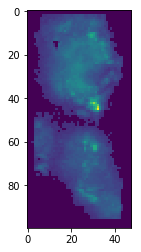

In [138]:
trunc = movB.copy()
thresh = np.percentile(np.ptp(movB[:,:,:10000],axis=2).reshape(-1),40)
trunc[np.where(np.ptp(movB[:,:,:10000],axis=2) < thresh)[0],np.where(np.ptp(movB[:,:,:10000],axis=2) < thresh)[1],:] = 0
plt.imshow(np.ptp(trunc,axis=2))


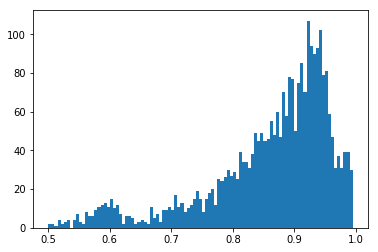

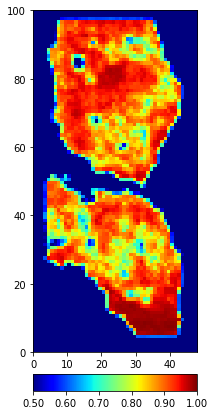

In [137]:
corr = util_plot.local_correlations_fft(trunc[:,:,:10000])
plt.hist(corr.flatten(),bins=[x / 1000.0 for x in range(500, 1000, 5)])
util_plot.show_img(corr,vmin=0.5,vmax=1)

In [6]:
# import manually initialized background components

ff_ini = io.imread(path + '/ff.tif')
fb_ini = io.imread(path + '/fb.tif')

fb_ini.shape

(20240, 6)

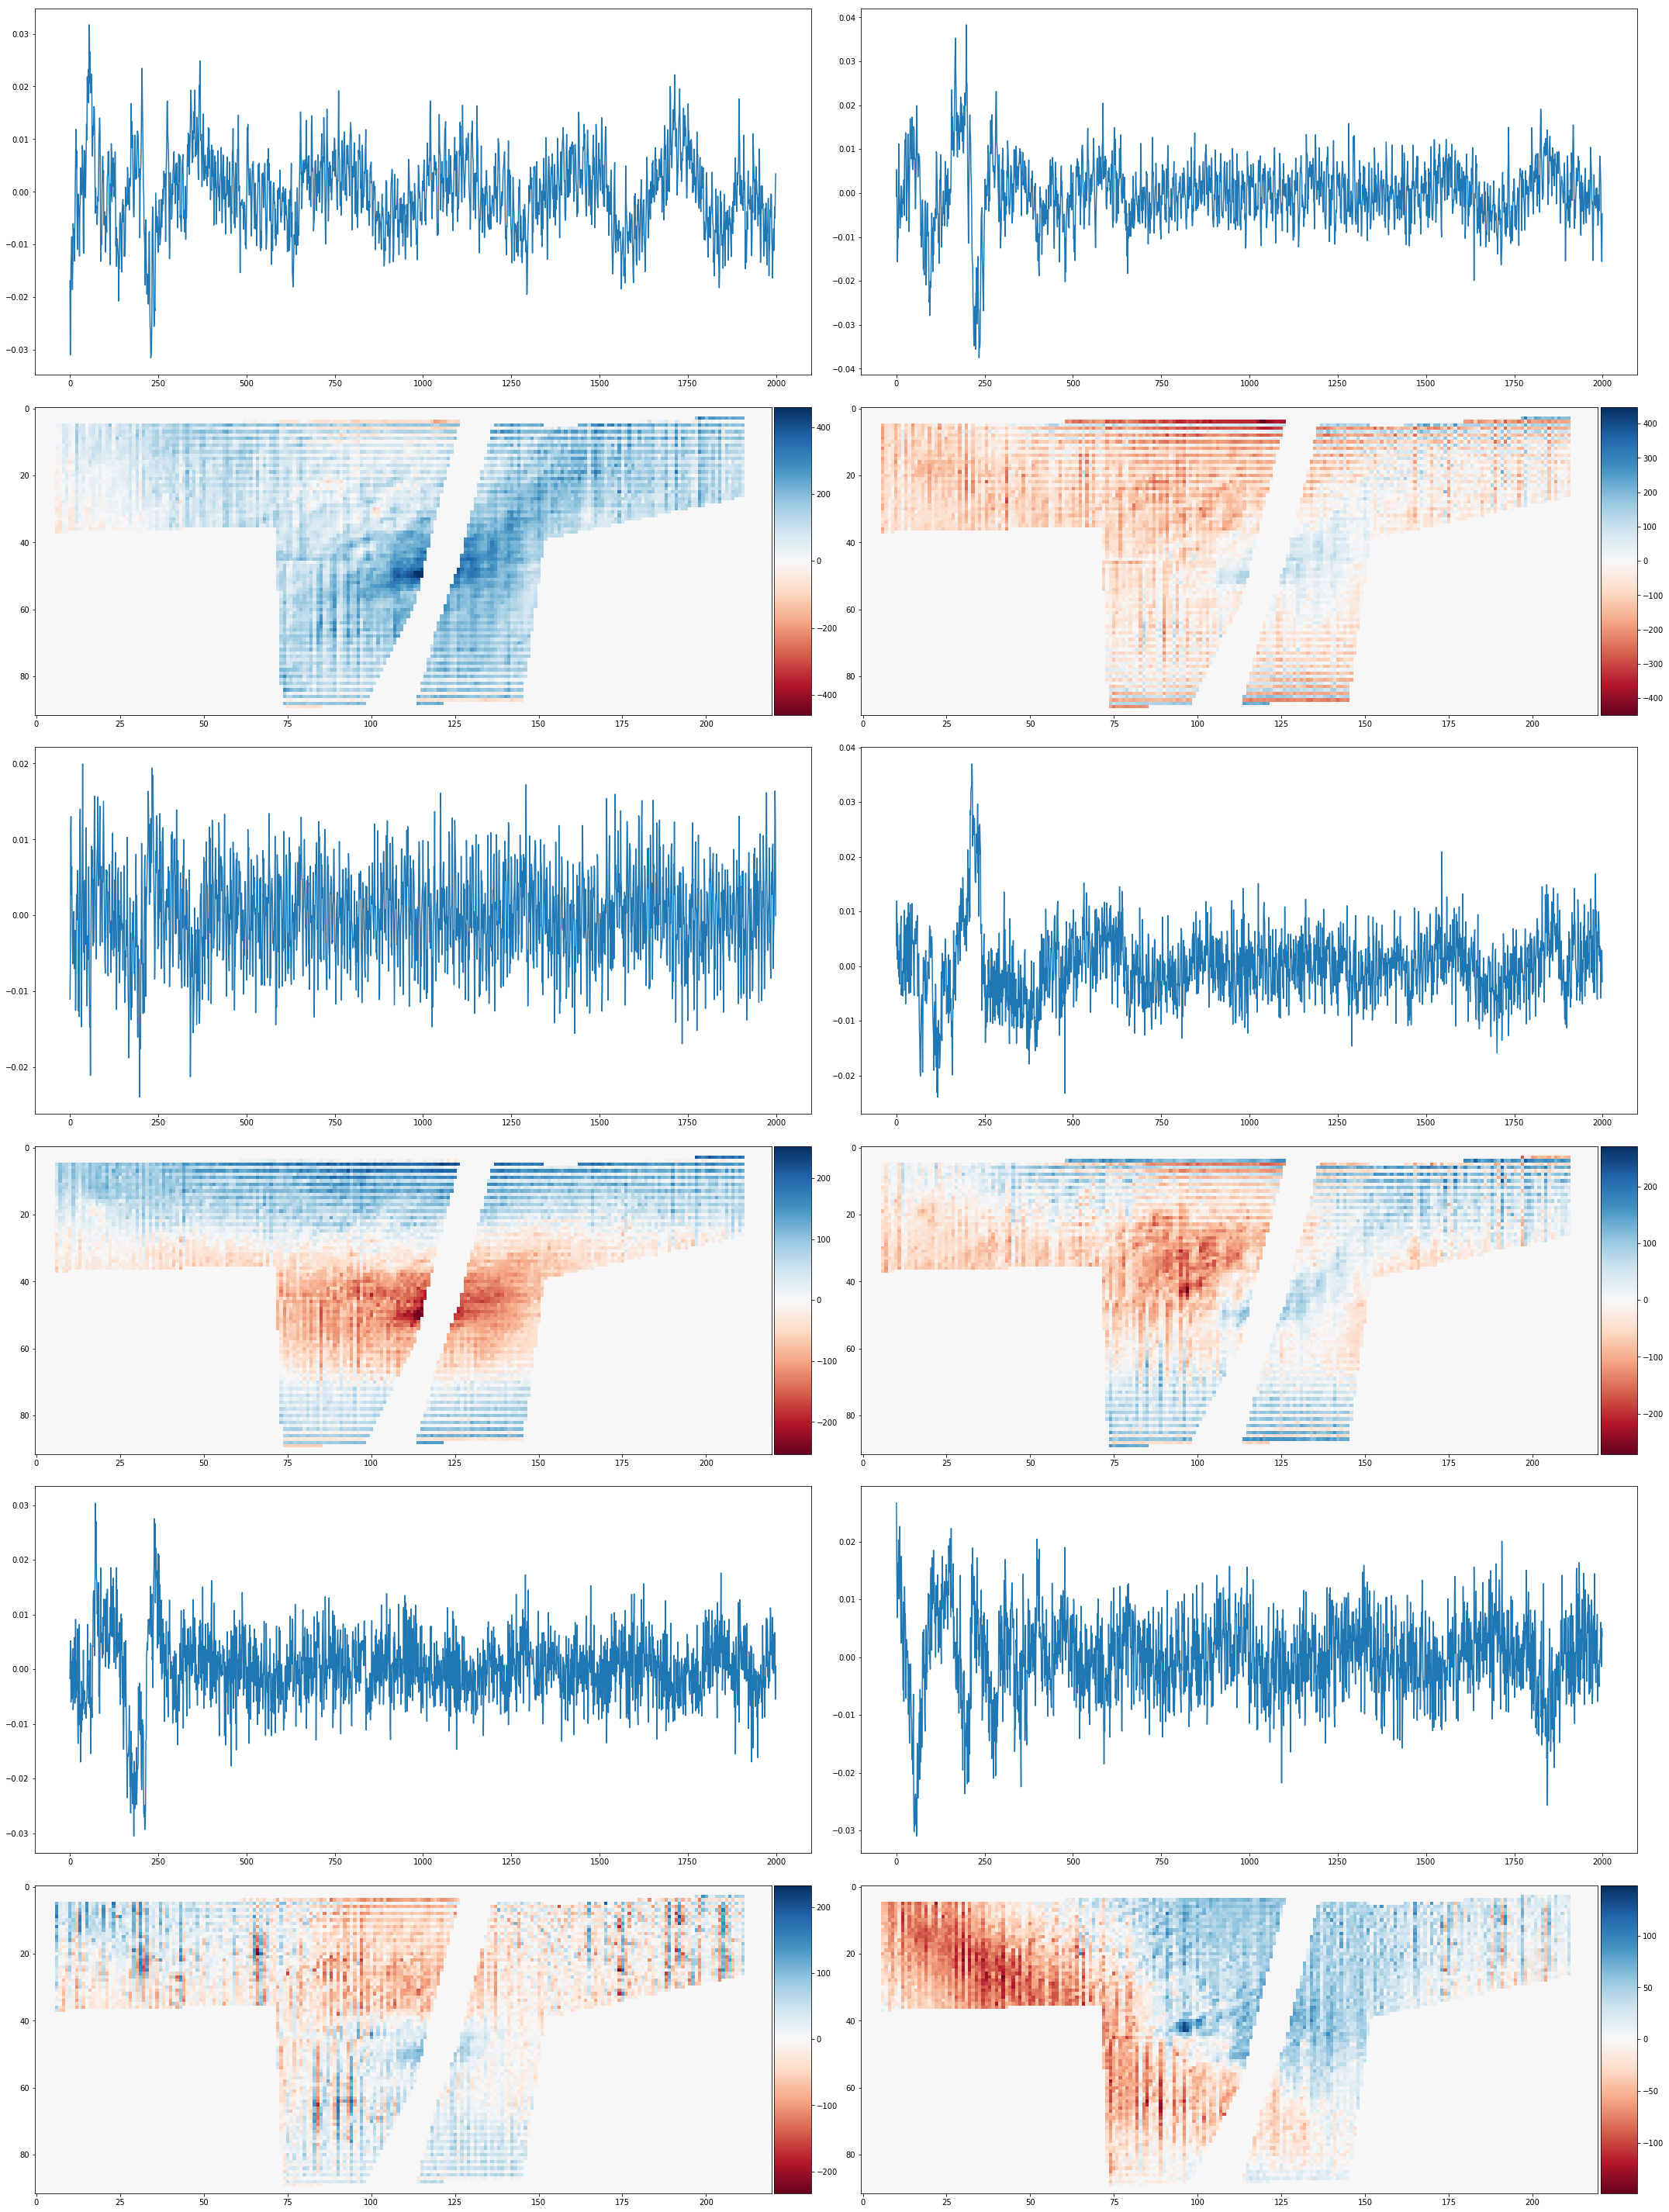

In [7]:
# plot manually initialized background components

plt.figure(figsize=(30,40))

plt.subplot(6,2,1)
plt.plot(ff_ini[:2000,0])
plt.subplot(6,2,2)
plt.plot(ff_ini[:2000,1])
plt.subplot(6,2,3)
io.imshow(fb_ini[:,0].reshape(mov.shape[1::-1]).transpose(1,0))
plt.subplot(6,2,4)
io.imshow(fb_ini[:,1].reshape(mov.shape[1::-1]).transpose(1,0))

plt.subplot(6,2,5)
plt.plot(ff_ini[:2000,2])
plt.subplot(6,2,6)
plt.plot(ff_ini[:2000,3])
plt.subplot(6,2,7)
io.imshow(fb_ini[:,2].reshape(mov.shape[1::-1]).transpose(1,0))
plt.subplot(6,2,8)
io.imshow(fb_ini[:,3].reshape(mov.shape[1::-1]).transpose(1,0))

plt.subplot(6,2,9)
plt.plot(ff_ini[:2000,4])
plt.subplot(6,2,10)
plt.plot(ff_ini[:2000,5])
plt.subplot(6,2,11)
io.imshow(fb_ini[:,4].reshape(mov.shape[1::-1]).transpose(1,0))
plt.subplot(6,2,12)
io.imshow(fb_ini[:,5].reshape(mov.shape[1::-1]).transpose(1,0))

In [ ]:
# select manually initialized background components
fb_ini = fb_ini[:,(0,1,2)].reshape(mov.shape[1],mov.shape[0],3).transpose(1,0,2).reshape(mov.shape[0]*mov.shape[1],3)
ff_ini = ff_ini[:,(0,1,2)]

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


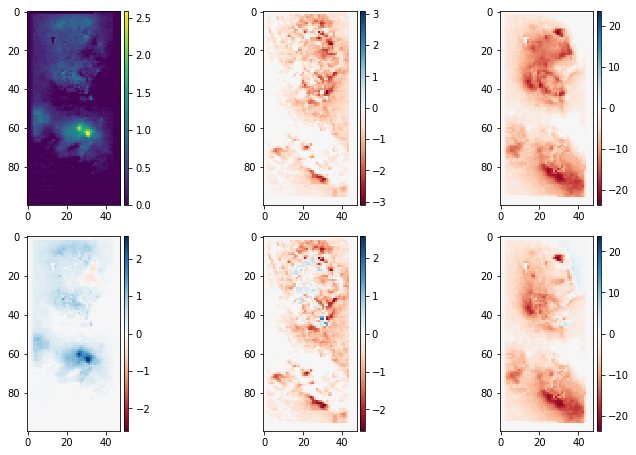

In [16]:
# display for decorrellated footprints

plt.figure(figsize=(10,25))
plt.subplot(8,3,1)
io.imshow(X[:,7].reshape(movB.shape[1::-1]).transpose(1,0))
plt.subplot(8,3,2)
io.imshow(X[:,8].reshape(movB.shape[1::-1]).transpose(1,0))
plt.subplot(8,3,3)
io.imshow(X[:,9].reshape(movB.shape[1::-1]).transpose(1,0))

plt.subplot(8,3,4)
io.imshow(X2[:,2].reshape(movB.shape[1::-1]).transpose(1,0))
plt.subplot(8,3,5)
io.imshow(X2[:,3].reshape(movB.shape[1::-1]).transpose(1,0))
plt.subplot(8,3,6)
io.imshow(X2[:,4].reshape(movB.shape[1::-1]).transpose(1,0))

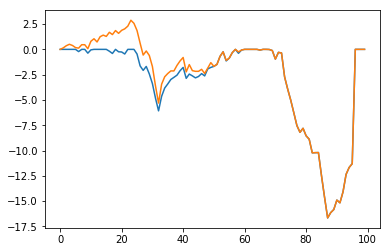

In [23]:
plt.plot(X[:,9].reshape(movB.shape[1::-1]).transpose(1,0)[:,40])
plt.plot(X2[:,4].reshape(movB.shape[1::-1]).transpose(1,0)[:,40])

In [5]:
X2 = io.imread(path + '/spatial_footprints.tif')
beta_hat2 = io.imread(path + '/temporal_traces.tif')